In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
# from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, VGG19
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [3]:
import cv2

Загружаем картинки для сегментации (имена почти одинаковые: изображение.png - это сам кадр и изображение (1).png - это разметка)

### Возьмем VGG19 (принимает на вход изображения квадратной формы) и Oxdord-IIIT Pets (128х128)

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [5]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

ds_names = ( 'oxford_iiit_pet:3.*.*',)
dataset_all, info = tfds.load(ds_names[0], split = ['train[:10%]','test[-10%:]'], with_info=True)

In [6]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/home/mitko/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits=

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [8]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // 10 // BATCH_SIZE

In [11]:
train = dataset_all[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset_all[1].map(load_image_test)

In [12]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Давайте посмотрим на пример  изображения из датасета и соотвествующую ему маску из датасета.

In [13]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

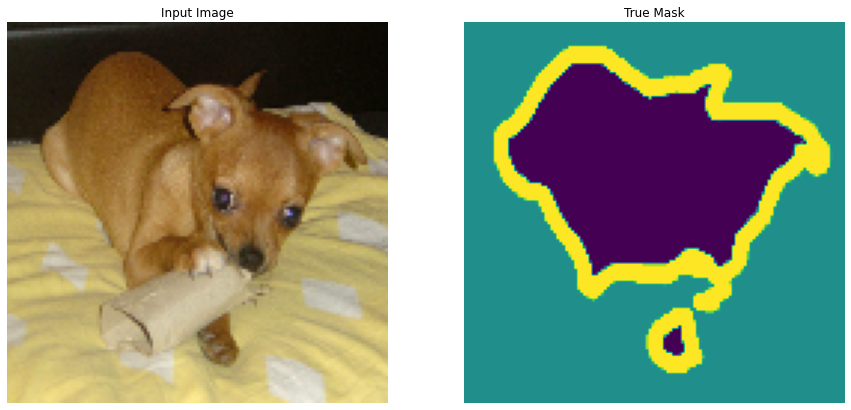

In [14]:
for image, mask in test_dataset.take(1):
  sample_image, sample_mask = image, mask
display([sample_image[3,:,:,:], sample_mask[3,:,:,:]])

In [15]:
sample_mask.numpy().min(),sample_mask.numpy().max()

(0.0, 2.0)

In [16]:
sample_image[3,:,:,:].shape

TensorShape([128, 128, 3])

In [17]:
sample_mask.dtype

tf.float32

### Построим модель

In [18]:
V_model = VGG19(input_shape=[128, 128, 3], include_top=False)

In [19]:
V_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [20]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [21]:
def vgg_pre_train(num_classes = 13, input_shape= (128, 128, 3)):    
    pre_trained_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers:
      layer.trainable = False
    x = pre_trained_model.get_layer('block4_conv4').output # конец сверток
    print('x', x.shape)
    block_4_out = pre_trained_model.get_layer('block4_conv1').output 
    print('4', block_4_out.shape)
    block_3_out = pre_trained_model.get_layer('block3_conv4').output 
    print('3', block_3_out.shape)
    block_2_out = pre_trained_model.get_layer('block2_conv2').output 
    print('2', block_2_out.shape)
    img_input = pre_trained_model.inputs

    # UP 1
    
    
    # добавили перенос из понижаюшего плеча
    x = bloc_transpose(x, block_4_out, numb_filter = [256, 256])
    
    
    # UP 2

    
    # добавили перенос из понижаюшего плеча
    x = bloc_transpose(x, block_3_out, numb_filter = [128, 128])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча
    x = bloc_transpose(x, block_2_out, numb_filter = [64,64])


    # UP 4
   
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [22]:
V_model = vgg_pre_train(num_classes = 3, input_shape= (128, 128, 3))

# plot_model(MN_model, to_file='MN_model.png')

x (None, 16, 16, 512)
4 (None, 16, 16, 512)
3 (None, 32, 32, 256)
2 (None, 64, 64, 128)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
______

In [23]:
from IPython.display import clear_output

### Вопрос: почему мы 2 раза компиллируем? Я убрала блок, который ниже, и все поломалось. 

In [32]:
V_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[dice_coef])
V_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [33]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [34]:
def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(1)
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image[0,:,:,:], sample_mask[0,:,:,:],
             create_mask(model.predict(sample_image[:,:,:]))])

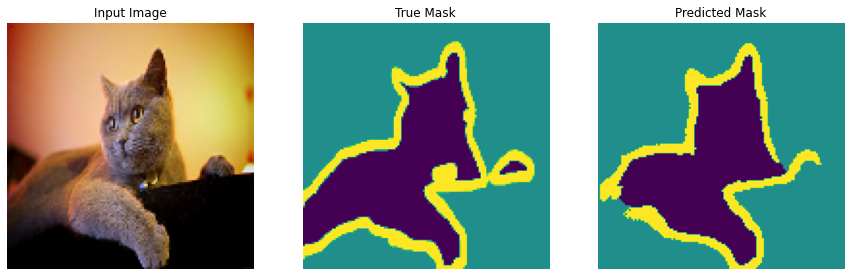

In [35]:
show_predictions(V_model)

In [36]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(V_model, train_dataset)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1


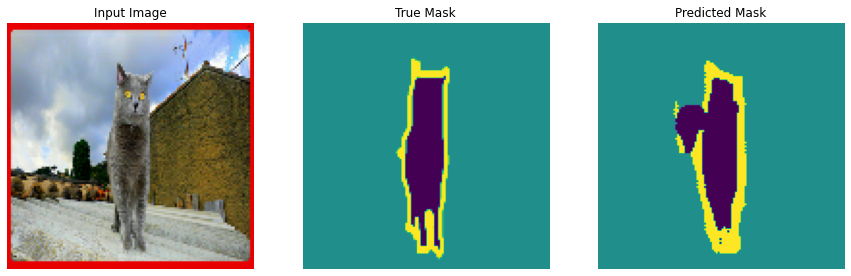


Sample Prediction after epoch 5



In [37]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = V_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

1


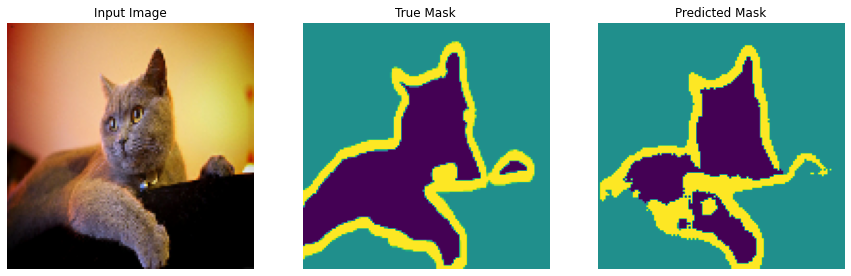

1


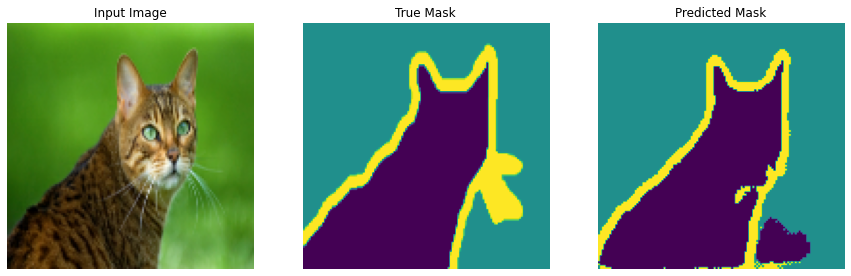

1


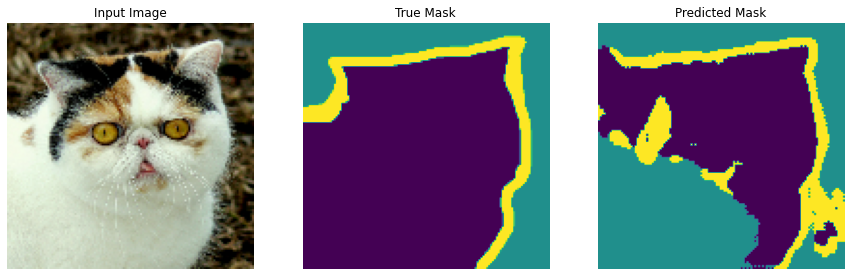

1


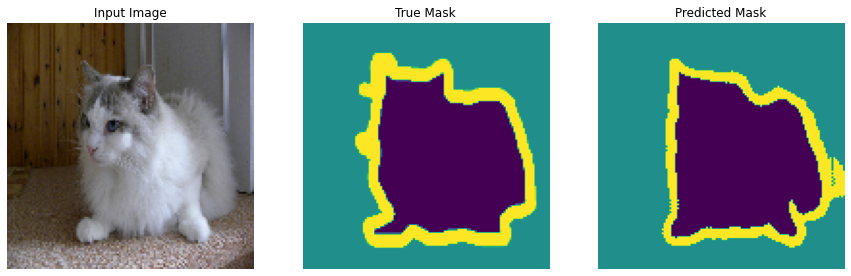

1


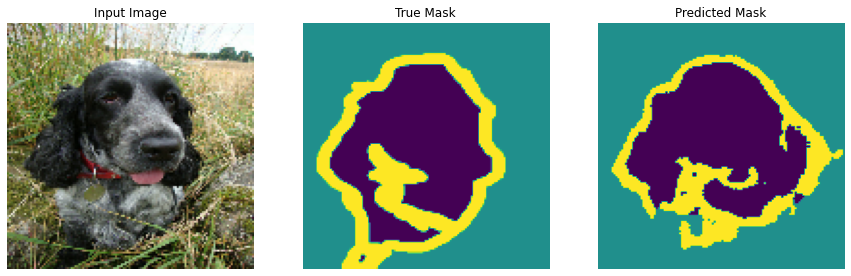

In [38]:
show_predictions(V_model, test_dataset, 5)

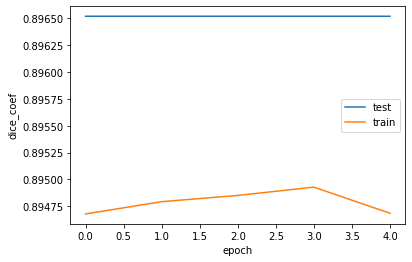

In [39]:
plt.plot(model_history.history['val_dice_coef'],label = 'test')
plt.plot(model_history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

### Смогла присоединить еще ResNet, но результата не получила практически. Потом еще повожусь с MobileNet, мне кажется, она должна подойти, но там не совсем разобралась со слоями (какие выбрать, и как их коннектить).